# Download the UCI Adult Dataset
We will download the UCI Adult dataset from the UCI Machine Learning Repository using Python.

In [1]:
import os
import pandas as pd
import requests

# URLs for the UCI Adult dataset
data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
test_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test'

# Filenames to save the datasets
os.makedirs('data', exist_ok=True)
data_path = 'data/adult.data'
test_path = 'data/adult.test'

# Download the training data
if not os.path.exists(data_path):
    response = requests.get(data_url)
    with open(data_path, 'wb') as f:
        f.write(response.content)
    print('Downloaded adult.data')
else:
    print('adult.data already exists')

# Download the test data
if not os.path.exists(test_path):
    response = requests.get(test_url)
    with open(test_path, 'wb') as f:
        f.write(response.content)
    print('Downloaded adult.test')
else:
    print('adult.test already exists')

adult.data already exists
adult.test already exists


# Load and Split the UCI Adult Dataset
We will load both the training and test datasets into pandas DataFrames. The test file contains a comment in the first line, which we will skip. We will then concatenate both datasets and perform a new random train/test split for better distribution.

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Column names from UCI repository
df_columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
    'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
    'hours-per-week', 'native-country', 'income'
]

# Load training data
df_train = pd.read_csv('data/adult.data', header=None, names=df_columns, skipinitialspace=True)

# Load test data, skipping the first line (comment)
df_test = pd.read_csv('data/adult.test', header=0, names=df_columns, skiprows=1, skipinitialspace=True, comment='|')

# Remove trailing period in income column for test set (if present)
df_test['income'] = df_test['income'].str.replace('.', '', regex=False).str.strip()

# Concatenate for a new split
df_all = pd.concat([df_train, df_test], ignore_index=True)

# Data Preprocessing: Handle Missing Values and Whitespace
We will start preprocessing by:
- Replacing '?' with NaN to mark missing values
- Trimming whitespace from all string columns
- Checking the number of missing values per column

In [14]:
import numpy as np

# Replace '?' with NaN for missing value handling
for col in df_all.columns:
    df_all[col] = df_all[col].replace('?', np.nan)
    # Trim whitespace for string columns
    if df_all[col].dtype == 'object':
        df_all[col] = df_all[col].str.strip()

# Show missing value counts per column
missing_counts = df_all.isnull().sum()
print('Missing values per column:')
print(missing_counts)

df_all.head()

# New train/test split (e.g., 80/20)
df_train_new, df_test_new = train_test_split(df_all, test_size=0.2, random_state=430, stratify=df_all['income'])

print(f'New training set: {df_train_new.shape[0]} rows')
print(f'New test set: {df_test_new.shape[0]} rows')

Missing values per column:
age                  0
workclass         2799
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     857
income               0
dtype: int64
New training set: 39072 rows
New test set: 9769 rows


We will demonstrate two common strategies for handling missing values in categorical columns:
- Drop rows with missing values (strict approach)
- Fill missing values with a new category 'Unknown' (imputation approach)

These will be applied separately to the training and test sets.

In [17]:
# Identify categorical columns with missing values
cat_missing_cols = ['workclass', 'occupation', 'native-country']

# --- Version 1: Drop rows with missing values ---
df_train_dropna = df_train_new.dropna(subset=cat_missing_cols).reset_index(drop=True)
df_test_dropna = df_test_new.dropna(subset=cat_missing_cols).reset_index(drop=True)
print(f"[Dropna] Train shape: {df_train_dropna.shape}, Test shape: {df_test_dropna.shape}")

# --- Version 2: Fill missing values with 'Unknown' ---
df_train_fillna = df_train_new.copy()
df_test_fillna = df_test_new.copy()
for col in cat_missing_cols:
    df_train_fillna[col] = df_train_fillna[col].fillna('Unknown')
    df_test_fillna[col] = df_test_fillna[col].fillna('Unknown')
print(f"[Fillna] Train shape: {df_train_fillna.shape}, Test shape: {df_test_fillna.shape}")


[Dropna] Train shape: (36138, 15), Test shape: (9083, 15)
[Fillna] Train shape: (39072, 15), Test shape: (9769, 15)


# Encoding Categorical Variables
We will encode the categorical variables in both the dropna and fillna versions of the data. For demonstration, we will show both label encoding (suitable for tree-based models) and one-hot encoding (suitable for linear models and neural networks). The target column `income` will also be converted to binary.

In [24]:
from sklearn.preprocessing import LabelEncoder

# Identify categorical columns (excluding the target)
categorical_cols = [col for col in df_train_dropna.columns if df_train_dropna[col].dtype == 'object' and col != 'income']

# Label Encoding for dropna version
le_dict_dropna = {col: LabelEncoder().fit(df_train_dropna[col]) for col in categorical_cols}
le_income_dropna = LabelEncoder().fit(df_train_dropna['income'])

df_train_dropna_le = df_train_dropna.copy()
df_test_dropna_le = df_test_dropna.copy()
for col in categorical_cols:
    df_train_dropna_le[col] = le_dict_dropna[col].transform(df_train_dropna[col])
    df_test_dropna_le[col] = le_dict_dropna[col].transform(df_test_dropna[col])
df_train_dropna_le['income'] = le_income_dropna.transform(df_train_dropna['income'])
df_test_dropna_le['income'] = le_income_dropna.transform(df_test_dropna['income'])

# Label Encoding for fillna version
le_dict_fillna = {col: LabelEncoder().fit(df_train_fillna[col]) for col in categorical_cols}
le_income_fillna = LabelEncoder().fit(df_train_fillna['income'])

df_train_fillna_le = df_train_fillna.copy()
df_test_fillna_le = df_test_fillna.copy()
for col in categorical_cols:
    df_train_fillna_le[col] = le_dict_fillna[col].transform(df_train_fillna[col])
    df_test_fillna_le[col] = le_dict_fillna[col].transform(df_test_fillna[col])
df_train_fillna_le['income'] = le_income_fillna.transform(df_train_fillna['income'])
df_test_fillna_le['income'] = le_income_fillna.transform(df_test_fillna['income'])

print('Label encoding complete.')

Label encoding complete.


In [25]:
# One-hot encoding for dropna version
df_train_dropna_oh = pd.get_dummies(df_train_dropna, columns=categorical_cols)
df_test_dropna_oh = pd.get_dummies(df_test_dropna, columns=categorical_cols)

# Align columns to ensure test set matches train set
df_test_dropna_oh = df_test_dropna_oh.reindex(columns=df_train_dropna_oh.columns, fill_value=0)

# Convert target to binary
le_income_dropna_oh = LabelEncoder().fit(df_train_dropna_oh['income'])
df_train_dropna_oh['income'] = le_income_dropna_oh.transform(df_train_dropna_oh['income'])
df_test_dropna_oh['income'] = le_income_dropna_oh.transform(df_test_dropna_oh['income'])

print('One-hot encoding complete. (dropna)')

# One-hot encoding for fillna version
df_train_fillna_oh = pd.get_dummies(df_train_fillna, columns=categorical_cols)
df_test_fillna_oh = pd.get_dummies(df_test_fillna, columns=categorical_cols)

# Align columns to ensure test set matches train set
df_test_fillna_oh = df_test_fillna_oh.reindex(columns=df_train_fillna_oh.columns, fill_value=0)

# Convert target to binary
le_income_oh = LabelEncoder().fit(df_train_fillna_oh['income'])
df_train_fillna_oh['income'] = le_income_oh.transform(df_train_fillna_oh['income'])
df_test_fillna_oh['income'] = le_income_oh.transform(df_test_fillna_oh['income'])

print('One-hot encoding complete. (fillna)')


One-hot encoding complete. (dropna)
One-hot encoding complete. (fillna)


# Final Preprocessing Checks and Recommendations
Before concluding preprocessing, it's important to check for:
- Feature scaling needs (for non-tree models)
- Outliers in numerical features
- Class imbalance in the target
- Highly correlated or redundant features
- Unexpected values or types

Below are code cells to help you perform these checks.

In [26]:
# 1. Feature Scaling (example: StandardScaler for numerical columns)
from sklearn.preprocessing import StandardScaler

numerical_cols = [col for col in df_train_dropna.columns if df_train_dropna[col].dtype in ['int64', 'float64'] and col != 'income']
scaler = StandardScaler()
df_train_dropna_le_scaled = df_train_dropna_le.copy()
df_test_dropna_le_scaled = df_test_dropna_le.copy()
df_train_dropna_le_scaled[numerical_cols] = scaler.fit_transform(df_train_dropna_le[numerical_cols])
df_test_dropna_le_scaled[numerical_cols] = scaler.transform(df_test_dropna_le[numerical_cols])
print('Feature scaling complete. (dropna):')

df_train_fillna_le_scaled = df_train_fillna_le.copy()
df_test_fillna_le_scaled = df_test_fillna_le.copy()
df_train_fillna_le_scaled[numerical_cols] = scaler.fit_transform(df_train_fillna_le[numerical_cols])
df_test_fillna_le_scaled[numerical_cols] = scaler.transform(df_test_fillna_le[numerical_cols])
print('Feature scaling complete. (fillna):')

Feature scaling complete. (dropna):
Feature scaling complete. (fillna):


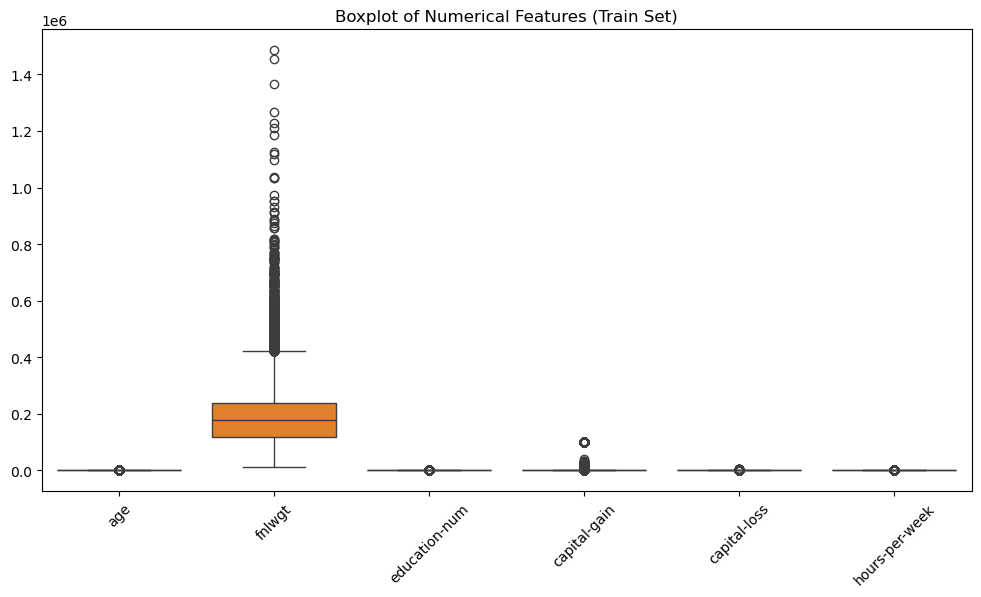

In [27]:
# 2. Outlier Detection (example: boxplot for numerical columns)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_train_dropna[numerical_cols])
plt.title('Boxplot of Numerical Features (Train Set)')
plt.xticks(rotation=45)
plt.show()

In [28]:
# 3. Class Imbalance Check
print('Class distribution in train set:')
print(df_train_dropna['income'].value_counts(normalize=True))

Class distribution in train set:
income
<=50K    0.752172
>50K     0.247828
Name: proportion, dtype: float64


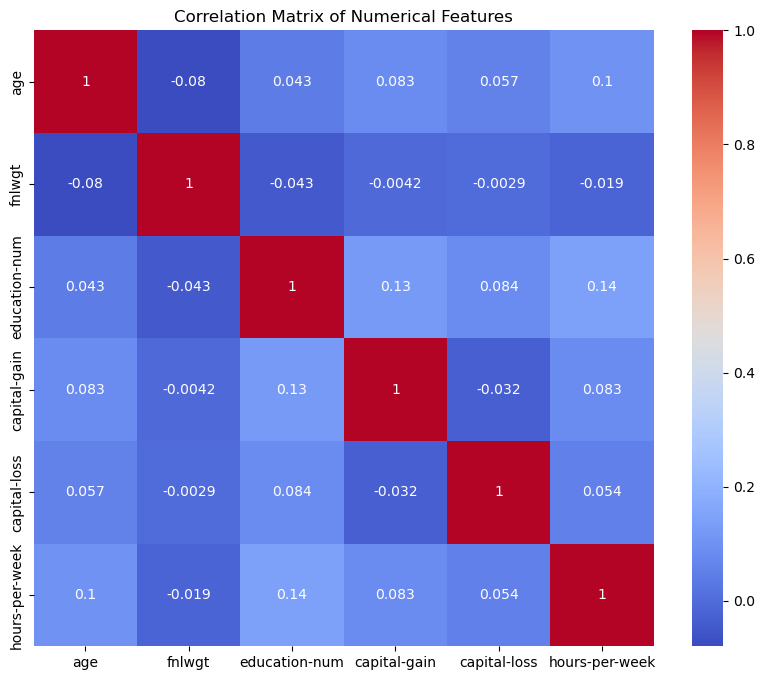

In [29]:
# 4. Correlation Check (example: correlation matrix for numerical features)
correlation_matrix = df_train_dropna[numerical_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [30]:
# 5. Final Data Inspection
print('Train set info:')
df_train_dropna.info()
print('\nTest set info:')
df_test_dropna.info()

Train set info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36138 entries, 0 to 36137
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             36138 non-null  int64 
 1   workclass       36138 non-null  object
 2   fnlwgt          36138 non-null  int64 
 3   education       36138 non-null  object
 4   education-num   36138 non-null  int64 
 5   marital-status  36138 non-null  object
 6   occupation      36138 non-null  object
 7   relationship    36138 non-null  object
 8   race            36138 non-null  object
 9   sex             36138 non-null  object
 10  capital-gain    36138 non-null  int64 
 11  capital-loss    36138 non-null  int64 
 12  hours-per-week  36138 non-null  int64 
 13  native-country  36138 non-null  object
 14  income          36138 non-null  object
dtypes: int64(6), object(9)
memory usage: 4.1+ MB

Test set info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9083 entrie